# Requirements

In [6]:
# now, import these modules into your code
''' here, we use the wide-spread standard for 
    pandas and numpy library '''
!pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import pandas as pd
import mne
import os
import scipy
import matplotlib.pyplot as plt
import torch
import re
# you can read more documentation about this
# extension for mne at: 
# https://github.com/mne-tools/mne-icalabel/blob/main/examples/00_iclabel.py
from mne_icalabel import label_components

# Functions



In [2]:
# function to save to a csv
def preprocessed_eeg_to_csv(eeg_data, path):
    # Convert the RawArray data to a pandas DataFrame
    df = pd.DataFrame(data=eeg_data.get_data().T, columns=eeg_data.ch_names);

    path = path.replace("data_porn_addiction\\raw", "data_porn_addiction\\preprocessed");
    # Extract the directory path
    directory_path = os.path.dirname(path);
    # Create the directory if it doesn't exist
    os.makedirs(directory_path, exist_ok=True);
    # Save the DataFrame to a CSV file
    df.to_csv(path, index=False);
    print(f'file: {path} --- has been written')
    return
# files into an organized structure (dictionary)
def get_csv_paths_by_subfolder(root_folder):
    csv_paths_by_subfolder = {};

    # Walk through the directory tree
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            # Check if the file has a .csv extension
            if file.endswith('.csv'):
                # Get the name of the subfolder
                subfolder_name = os.path.basename(root);
                
                # Construct the full path to the CSV file
                csv_path = os.path.join(root, file);

                # Append the CSV path to the subfolder's list in the dictionary
                if subfolder_name not in csv_paths_by_subfolder:
                    csv_paths_by_subfolder[subfolder_name] = [];
                csv_paths_by_subfolder[subfolder_name].append(csv_path);

    return csv_paths_by_subfolder

# function to create eeg_raw objects
def import_preprocessed_signals(path, channels):
    #ch_names = ['P4','O2','P8','T8','C4','Cz','Fz','F4','Fp2','F8','Fp1','F7','F3','C3','T7','P7','P3','O1','Pz'];

    #path to eeg
    eeg_pandas = pd.read_csv(path, usecols=channels, delimiter=",");
    eeg_pandas=eeg_pandas.fillna(0);
    
    return eeg_pandas

# Function to apply bandpass filter to a vector/signal
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs;
    low = lowcut / nyquist;
    high = highcut / nyquist;
    b, a = scipy.signal.butter(order, [low, high], btype='band');
    filtered_data = scipy.signal.filtfilt(b, a, data);
    return filtered_data

# map a filter function to every column of a pd.dataframe
def eeg_apply_filter(data,lowcut, highcut, fs):
    #initialize the df to store the filtered signals
    filtered_signal = pd.DataFrame({});
    for column in data.columns:
        filtered_signal[column] = bandpass_filter(data[column].values, lowcut, highcut, fs);
    return filtered_signal



# Alpha filter

In [3]:
# Define alpha filter parameters
lowcut = 8.0;  # Lower cutoff frequency in Hz
highcut = 12.0;  # Upper cutoff frequency in Hz
fs = 250.0;  # Sampling frequency in Hz

In [4]:
csv_paths_by_subject = get_csv_paths_by_subfolder("/Users/monica/Documents/data_porn_addiction_prepocessed");

happy = [];
sad = [];
calm = [];
fear = [];

#Get the path for the emotion files
for subject, files in csv_paths_by_subject.items():
    # Separate emotions
    path_h = [item for item in files if 'H.csv' in item];
    happy.extend(path_h)
    path_s = [item for item in files if 'S.csv' in item];
    sad.extend(path_s)
    path_c = [item for item in files if 'C.csv' in item];
    calm.extend(path_c)
    path_f = [item for item in files if 'F.csv' in item];
    fear.extend(path_f)



In [5]:
#processed_data contains eeg avg signals powers by subject, by window for each electrode
ch_names = ['Fz','F4','Fp2','F8','Fp1','F7','F3']; 
ch_names_s = ['Fz_s','F4_s','Fp2_s','F8_s','Fp1_s','F7_s','F3_s'];
ch_names_c = ['Fz_c','F4_c','Fp2_c','F8_c','Fp1_c','F7_c','F3_c'];
ch_names_f = ['Fz_f','F4_f','Fp2_f','F8_f','Fp1_f','F7_f','F3_f'];


#Select the length for the epochs and window overlap
epoch_length_seconds = 5;
window_overlap = 2.5;
step_samples = int((epoch_length_seconds - window_overlap)* 250);

subject_labels = [];  # Initialize list to store subject labels
happy_data = [];  # Initialize list to store row data as dictionaries
sad_data = [];
calm_data = [];
fear_data = [];
sub = [];

for file_h, file_s, file_c, file_f in zip(happy, sad, calm, fear):
    #Import data from each path for subject
    eeg_band_h = import_preprocessed_signals(file_h, ch_names);
    eeg_band_s = import_preprocessed_signals(file_s, ch_names);
    eeg_band_c = import_preprocessed_signals(file_c, ch_names);
    eeg_band_f = import_preprocessed_signals(file_f, ch_names);
    #filter data for alpha
    eeg_band_filt_h = eeg_apply_filter(eeg_band_h, lowcut, highcut, fs);
    eeg_band_filt_s = eeg_apply_filter(eeg_band_s, lowcut, highcut, fs);
    eeg_band_filt_c = eeg_apply_filter(eeg_band_c, lowcut, highcut, fs);
    eeg_band_filt_f = eeg_apply_filter(eeg_band_f, lowcut, highcut, fs);
    #Get the power of filtered data
    eeg_band_pow_h = eeg_band_filt_h.pow(2);
    eeg_band_pow_s = eeg_band_filt_s.pow(2);
    eeg_band_pow_c = eeg_band_filt_c.pow(2);
    eeg_band_pow_f = eeg_band_filt_f.pow(2);
    
    for i in range(0, eeg_band_pow_h.shape[0] - int(epoch_length_seconds * fs) + 1, step_samples):
        #get epochs
        window_mean_h = eeg_band_pow_h.iloc[i:i + int(epoch_length_seconds*fs), :].mean();
        window_mean_s = eeg_band_pow_s.iloc[i:i + int(epoch_length_seconds*fs), :].mean();
        window_mean_c = eeg_band_pow_c.iloc[i:i + int(epoch_length_seconds*fs), :].mean();
        window_mean_f = eeg_band_pow_f.iloc[i:i + int(epoch_length_seconds*fs), :].mean();
        # Append row data as a dictionary to happy and sad data and also get the subject
        happy_data.append(window_mean_h.T.to_dict());
        sad_data.append(window_mean_s.T.to_dict());
        calm_data.append(window_mean_c.T.to_dict());
        fear_data.append(window_mean_f.T.to_dict());
        sub.append(file_h.split('/')[-2]);

# Create a DataFrame from the list of dictionaries
features = pd.DataFrame(happy_data);
features_s = pd.DataFrame(sad_data);
features_c = pd.DataFrame(calm_data);
features_f = pd.DataFrame(fear_data);

features[['Fz_s','F4_s','Fp2_s','F8_s','Fp1_s','F7_s','F3_s']]= features_s
features[['Fz_c','F4_c','Fp2_c','F8_c','Fp1_c','F7_c','F3_c']]= features_c
features[['Fz_f','F4_f','Fp2_f','F8_f','Fp1_f','F7_f','F3_f']]= features_f

# Add a new column 'Subject' to the features DataFrame
features['Subject'] =  [item.upper() for item in sub];


yn = [];
addict = [1,5,6,9,10,11,14];
no_addict = [2,3,4,7,8,12,13]

#Classify if subject is addict or not
for subject in features['Subject']:
    sub_num = re.split('[sS]',subject)[1]
    if int(sub_num) in addict:
            yn.append(1);
    elif int(sub_num) in no_addict:
            yn.append(0);
features['AddictBoolean'] = yn


# Model

In [7]:
# Selecting feature columns for happy and sad subjects
feature_columns_happy = ['Fz', 'F4', 'Fp2', 'F8', 'Fp1', 'F7', 'F3']
feature_columns_sad = ['Fz_s', 'F4_s', 'Fp2_s', 'F8_s', 'Fp1_s', 'F7_s', 'F3_s']
feature_columns_calm = ['Fz_c','F4_c','Fp2_c','F8_c','Fp1_c','F7_c','F3_c']
feature_columns_fear = ['Fz_f','F4_f','Fp2_f','F8_f','Fp1_f','F7_f','F3_f']
# Split data into features (X) and labels (y)

X_happy = features[feature_columns_happy]
X_sad = features[feature_columns_sad]
X_calm = features[feature_columns_calm]
X_fear = features[feature_columns_fear]
y = features['AddictBoolean']

# Split the dataset into training and testing sets for happy and sad subjects
X_train_happy, X_test_happy, y_train_happy, y_test_happy = train_test_split(X_happy, y, test_size=0.2, random_state=42)
X_train_sad, X_test_sad, y_train_sad, y_test_sad = train_test_split(X_sad, y, test_size=0.2, random_state=42)
X_train_calm, X_test_calm, y_train_calm, y_test_calm = train_test_split(X_calm, y, test_size=0.2, random_state=42)
X_train_fear, X_test_fear, y_train_fear, y_test_fear = train_test_split(X_fear, y, test_size=0.2, random_state=42)


# Initialize LDA classifiers for happy and sad data
lda_happy = LinearDiscriminantAnalysis()
lda_sad = LinearDiscriminantAnalysis()
lda_calm = LinearDiscriminantAnalysis()
lda_fear = LinearDiscriminantAnalysis()


# Fit LDA models on training data for happy and sad subjects
lda_happy.fit(X_train_happy, y_train_happy)
lda_sad.fit(X_train_sad, y_train_sad)
lda_calm.fit(X_train_calm, y_train_calm)
lda_fear.fit(X_train_fear, y_train_fear)

# Make predictions on the testing data for happy and sad subjects
y_pred_happy = lda_happy.predict(X_test_happy)
y_pred_sad = lda_sad.predict(X_test_sad)
y_pred_calm = lda_calm.predict(X_test_calm)
y_pred_fear = lda_fear.predict(X_test_fear)

# Calculate accuracy scores for happy and sad subjects
accuracy_happy = accuracy_score(y_test_happy, y_pred_happy)
accuracy_sad = accuracy_score(y_test_sad, y_pred_sad)
accuracy_calm = accuracy_score(y_test_calm, y_pred_calm)
accuracy_fear = accuracy_score(y_test_fear, y_pred_fear)

# Print accuracy scores for happy and sad subjects
print("Accuracy for predicting happy subjects:", accuracy_happy)
print("Accuracy for predicting sad subjects:", accuracy_sad)
print("Accuracy for predicting calm subjects:", accuracy_calm)
print("Accuracy for predicting fear subjects:", accuracy_fear)

Accuracy for predicting happy subjects: 0.7076923076923077
Accuracy for predicting sad subjects: 0.7384615384615385
Accuracy for predicting calm subjects: 0.6615384615384615
Accuracy for predicting fear subjects: 0.7538461538461538


In [9]:
# Selecting feature columns
feature_columns = ['Fz_f','F4_f','Fp2_f','F8_f','Fp1_f','F7_f','F3_f', 'Fz_s', 'F4_s', 'Fp2_s', 'F8_s', 'Fp1_s', 'F7_s', 'F3_s']

# Split data into features (X) and labels (y)
X = features[feature_columns]  # Features
y = features['AddictBoolean']  # Labels

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize LDA classifier
lda = LinearDiscriminantAnalysis()

# Fit the classifier to the training data
lda.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = lda.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for sad and calm:", accuracy)


Accuracy for sad and calm: 0.7538461538461538


In [12]:
# Selecting feature columns
feature_columns = ['Fz','F4','Fp2','F8','Fp1','F7','F3', 'Fz_c', 'F4_c', 'Fp2_c', 'F8_c', 'Fp1_c', 'F7_c', 'F3_c']

# Split data into features (X) and labels (y)
X = features[feature_columns]  # Features
y = features['AddictBoolean']  # Labels

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize LDA classifier
lda = LinearDiscriminantAnalysis()

# Fit the classifier to the training data
lda.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = lda.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for happpy and calm:", accuracy)


Accuracy for happpy and calm: 0.8307692307692308


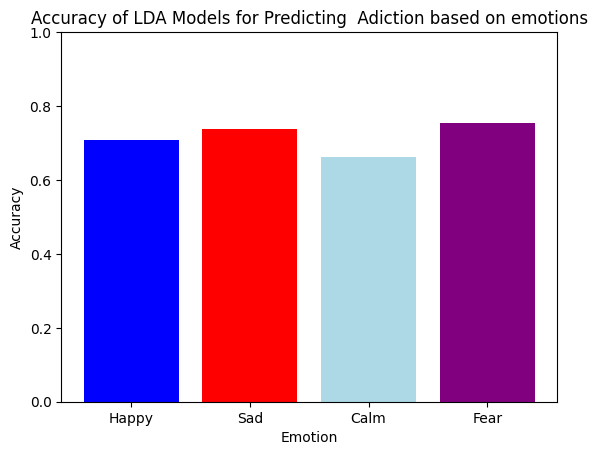

In [10]:
# Accuracy scores for happy and sad subjects
accuracy_scores = [accuracy_happy, accuracy_sad, accuracy_calm, accuracy_fear]
labels = ['Happy', 'Sad', 'Calm', 'Fear']

# Plotting the bar plot
plt.bar(labels, accuracy_scores, color=['blue', 'red', 'lightblue', 'purple'])
plt.xlabel('Emotion')
plt.ylabel('Accuracy')
plt.title('Accuracy of LDA Models for Predicting  Adiction based on emotions')
plt.ylim(0, 1)  # Limit y-axis to range between 0 and 1 for better visualization
plt.show()
